Deck quality analyzer (by Arseny Khakhalin). 

Forked from the general analysis script. This script assumes that the "Basic analysis" notebook was already run, and so both "basic_data" and "distances" CSV files are already saved.

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.manifold import MDS

In [2]:
from draftsim_utils_ab import *

# A set of useful utils: fixName(name), getName(card), isLegendary(card), getCardColor(card)
# where 'card' is a line in mtgJSON

Change the set abbrevation below to work with a different set:

In [3]:
# Alternatives: XLN, DOM, M19, GRN, RNA
setName = 'GRN'

In [4]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [5]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

# thisSet[list(thisSet.keys())[0]] # Full info for one card

Change the addresses below if you store data ini a different folder locally:

In [6]:
dataFileNames = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../2019-01-22 RNA merged.csv'
}

draftData = pd.read_csv('../'+dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

# draftData.head()
print('Loaded ', len(draftData['format']), " draft records.")

Loaded  118792  draft records.


In [7]:
# Read basic set data and card-to-card distances

df = pd.read_csv('basic_data_'+setName+'.csv')
df = df.set_index('name')

dist = np.genfromtxt('distances_'+setName+'.csv', delimiter=',')

df = df.loc[df.freq>0] # Remove cards that are formally in the set, but are actually never drafted

In [8]:
# Create a new df with a more inclusive color allocation (multis are counted as all colors)

df2 = df.copy()
colorLines = pd.DataFrame(
    { 'w': ['W' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'u': ['U' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'b': ['B' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'r': ['R' in thisSet[cardName]['colorIdentity'] for cardName in df2.index],
      'g': ['G' in thisSet[cardName]['colorIdentity'] for cardName in df2.index]},
             list(df2.index))
df2 = df2.join(colorLines)
#df2

In [9]:
# A tiny function that turns azorius_guildgate_2 to azorius_guildgate.
# Both df and carslist don't have these _2 cards, and so they aren't in the dist as well.
# Not sure why this error didn't come up earlier.

def fix_gates(cardName):
    if cardName[-2]=='_':
        return cardName[:-2]
    else:
        return cardName

In [10]:
# ----------------------
# Main loop (goes through hands and calculates their stats)
# ----------------------

colorList = ['w','u','b','r','g']
guildNames = {'wu':'Azo','uw':'Azo','wb':'Orz','bw':'Orz','wr':'Bor','rw':'Bor','wg':'Sel','gw':'Sel',
              'ub':'Dim','bu':'Dim','ur':'Izz','ru':'Izz','ug':'Sim','gu':'Sim',
              'br':'Rak','rb':'Rak','bg':'Gol','gb':'Gol',
              'rg':'Gru','gr':'Gru'}

maxDeckNumber = 5000 # <------------------ How many decks to use (set a real high number if you want all of them)

sumPick = [0]*maxDeckNumber # Sum of pick numbers (higher = worse)
sumDist = [0]*maxDeckNumber # Sum of distances from other cards (higher = worse)
draftCount = 0
guilds = [] # Code from a list

for hand in draftData['human'][0:maxDeckNumber]:
    hand = fixName(hand).lower().split(',')
    for icard in range(len(hand)):
        sumPick[draftCount] += df.loc[fix_gates(hand[icard])]['avg']
        for jcard in range(icard):
            sumDist[draftCount] += dist[cardlist.index(fix_gates(hand[jcard]))][cardlist.index(fix_gates(hand[icard]))]
    draftCount += 1
    
    colorCount = [0]*5
    for icolor in range(len(colorList)):
        colorCount[icolor] = sum(df2.loc[hand][colorList[icolor]])

    color1 = np.argmax(colorCount) # Most common color in this pile (excluding multicolors, which is suboptimal)
    colorCount[color1] = 0
    color2 = np.argmax(colorCount)

    guilds.append(guildNames[colorList[color1]+colorList[color2]])

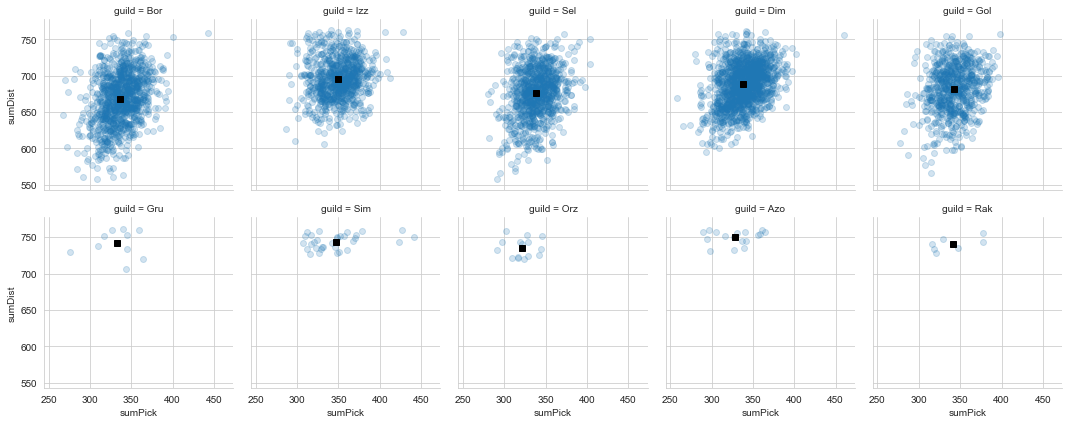

In [13]:
#myPal = sns.xkcd_palette(["gold","deep blue","black","red","green","lavender","grey"])
dataToPlot = pd.DataFrame({'sumPick': sumPick, 'sumDist': sumDist, 'guild': guilds})

sns.set_style("whitegrid")
g = sns.FacetGrid(dataToPlot, col="guild", col_wrap = 5, aspect = 1)
s = g.map(plt.scatter,"sumPick","sumDist",alpha=0.2)#,palette=myPal)
#s.fig.set_size_inches(7,6)
#s.despine(left=True,bottom=True)
#s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='');

def mean_point(x,y, **kwargs):
    plt.plot(x.mean(), y.mean(),'ks')
    #plt.text(x.mean()+1, 0.052, 'mean = '+str('%.2f'%x.mean()), size=12)
    #plt.text(x.mean()+1, 0.0455, 'std = '+str('%.2f'%x.std()), size=12)

g.map(mean_point, 'sumPick' , 'sumDist');

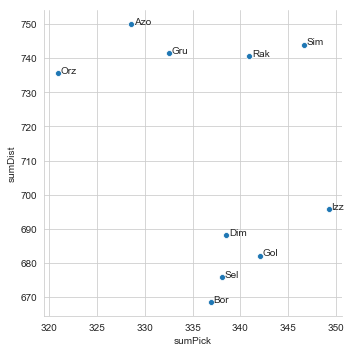

In [12]:
sumData = dataToPlot.groupby('guild').mean()

p1 = sns.relplot(data=sumData, x='sumPick', y='sumDist')

for iline in range(0,sumData.shape[0]):
    p1.axes[0,0].text(sumData['sumPick'][iline]+0.3, sumData['sumDist'][iline], sumData.index.values.tolist()[iline])

### Next steps:

First priority:

* ~~Sensitivity: same, but for bot drafts~~
* GRN
* Put in perspective: add random decks and "ideal decks" on the same plot
* Look at individual decks at extremes: best deck, wost, most synergistic, most bomby

Second priority:

* Simple Bot (fixed synergy / rating ratio across draft), % of match with humans
* Simple Bot, % of match with Dan bots (current draftsim)
* Compare average bot-drafted deck across guilds
